# Loading data for the neural network(and the metadata)

## loading the metadata dataframe( as a csv file) as well

In [2]:
import pandas as pd
meta_df = pd.read_csv("C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\meta_df.csv")


In [3]:
meta_df["Subject_Id"].head

<bound method NDFrame.head of 0     2010002
1     2010004
2     2010005
3     2010006
4     2010008
5     2010010
6     2010011
7     2010012
8     2010013
9     2010015
10    2010016
11    2010018
12    2010019
13    2010021
14    2010022
15    2010023
16    2010024
17    2010025
18    2010026
19    2010028
20    2010030
21    2010033
22    2010034
23    2010036
24    2020008
25    2020010
26    2020013
27    2020014
28    2020015
29    2020016
30    2020018
31    2020019
32    2020020
33    2020021
34    2020022
35    2020023
36    2020025
37    2020026
38    2020027
39    2020029
40    2030002
41    2030003
42    2030004
43    2030005
44    2030006
45    2030007
46    2030009
47    2030014
48    2030017
49    2030018
50    2030019
51    2030020
52    2030021
Name: Subject_Id, dtype: int64>

## Failed miserably in splitting data , now doing subject wise splitting so that EEGnet generalizes well

In [4]:
import os
import numpy as np
import pandas as pd
import mne
import re
from sklearn.preprocessing import LabelEncoder

# === Load metadata ===
meta_df = pd.read_csv(r"C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\meta_df.csv")

# === Folder with .fif files ===
fif_dir = r"C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\filtered128_folder"

def extract_subject_id(fname):
    match = re.match(r'(\d{7,8})', fname)
    return match.group(1) if match else None

X = []
y = []
subjects = []

for fname in sorted(os.listdir(fif_dir)):
    if fname.endswith('-epo.fif'):
        filepath = os.path.join(fif_dir, fname)
        subject_id = extract_subject_id(fname)
        if subject_id is None:
            print(f"Skipping {fname}: couldn't extract subject ID")
            continue
        sid_stripped = str(int(subject_id))  # Remove leading zeros

        if sid_stripped not in meta_df['Subject_Id'].astype(str).values:
            print(f"Skipping {fname}: subject ID {sid_stripped} not in metadata")
            continue

        try:
            epochs = mne.read_epochs(filepath, preload=True)
            data = epochs.get_data()  # (n_epochs, 128, 251)

            for epoch in data:
                norm = (epoch - np.mean(epoch, axis=1, keepdims=True)) / np.std(epoch, axis=1, keepdims=True)
                X.append(norm)
                label = meta_df.loc[meta_df['Subject_Id'].astype(str) == sid_stripped, 'type'].values[0]
                y.append(label)
                subjects.append(sid_stripped)

        except Exception as e:
            print(f"Skipping {fname}: {e}")

# === Convert to arrays ===
X = np.array(X)[..., np.newaxis]  # (N, 128, 251, 1)
y = LabelEncoder().fit_transform(y)
subjects = np.array(subjects)

# === Save for reuse ===
np.savez('modma_data_subjectwise.npz', X=X, y=y, subjects=subjects)

print(f"✅ Saved data — X shape: {X.shape}, y shape: {y.shape}, Unique subjects: {np.unique(subjects).shape[0]}")


Reading C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\filtered128_folder\02010002erp 20150416 1131-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\filtered128_folder\02010004erp 20141219 1602-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\filtered128_folder\02010005erp 20150507 0938-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matr

In [4]:
import os
import numpy as np
import pandas as pd
import mne
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# === Paths ===
meta_csv = r"C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\meta_df.csv"
fif_dir = r"C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\filtered128_folder"
output_path = r"C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\modma_subjectwise_split.npz"

# === Load metadata ===
meta_df = pd.read_csv(meta_csv)

def extract_subject_id(fname):
    match = re.match(r'(\d{7,8})', fname)
    return match.group(1) if match else None

# === Containers ===
X, y, subjects = [], [], []

# === Process each subject's .fif file ===
for fname in sorted(os.listdir(fif_dir)):
    if not fname.endswith('-epo.fif'):
        continue

    filepath = os.path.join(fif_dir, fname)
    subject_id = extract_subject_id(fname)

    if subject_id is None:
        print(f"Skipping {fname} (can't extract subject ID)")
        continue

    sid_stripped = str(int(subject_id))  # Remove leading zeros

    if sid_stripped not in meta_df['Subject_Id'].astype(str).values:
        print(f"Skipping {fname} (subject ID not in metadata)")
        continue

    try:
        epochs = mne.read_epochs(filepath, preload=True)
        data = epochs.get_data()  # shape: (n_epochs, 128, 251)

        for epoch in data:
            norm = (epoch - np.mean(epoch, axis=1, keepdims=True)) / np.std(epoch, axis=1, keepdims=True)
            X.append(norm)
            y.append(meta_df.loc[meta_df['Subject_Id'].astype(str) == sid_stripped, 'type'].values[0])
            subjects.append(sid_stripped)

    except Exception as e:
        print(f"Skipping {fname}: {e}")

# === Final arrays ===
X = np.array(X)[..., np.newaxis]  # shape: (n_epochs, 128, 251, 1)
y = LabelEncoder().fit_transform(y)
subjects = np.array(subjects)

# === Subject-wise split ===
unique_subjects = np.unique(subjects)
train_subj, test_subj = train_test_split(unique_subjects, test_size=0.2, random_state=42)

train_mask = np.isin(subjects, train_subj)
test_mask = np.isin(subjects, test_subj)

X_train, y_train, subj_train = X[train_mask], y[train_mask], subjects[train_mask]
X_test, y_test, subj_test = X[test_mask], y[test_mask], subjects[test_mask]

# === Save ===
np.savez_compressed(
    output_path,
    X_train=X_train,
    y_train=y_train,
    subj_train=subj_train,
    X_test=X_test,
    y_test=y_test,
    subj_test=subj_test
)

print("✅ Done. Data saved at:", output_path)
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")
print(f"Subjects in train: {len(np.unique(subj_train))}, test: {len(np.unique(subj_test))}")


Reading C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\filtered128_folder\02010002erp 20150416 1131-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\filtered128_folder\02010004erp 20141219 1602-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\filtered128_folder\02010005erp 20150507 0938-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matr

### Subject wise splitting (did normalizations for each epoch which sparses variances which are useful) so doing actual sub wise norms

In [6]:
import os
import numpy as np
import pandas as pd
import mne
import re
from sklearn.preprocessing import LabelEncoder

meta_df = pd.read_csv(r"C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\meta_df.csv")
fif_dir = r"C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\filtered128_folder"

def extract_subject_id(fname):
    match = re.match(r'(\d{7,8})', fname)
    return match.group(1) if match else None

X = []
y = []
subjects = []

for fname in sorted(os.listdir(fif_dir)):
    if not fname.endswith('-epo.fif'):
        continue

    filepath = os.path.join(fif_dir, fname)
    subject_id = extract_subject_id(fname)
    if not subject_id:
        continue
    sid_stripped = str(int(subject_id))

    if sid_stripped not in meta_df['Subject_Id'].astype(str).values:
        continue

    try:
        epochs = mne.read_epochs(filepath, preload=True)
        data = epochs.get_data()  # (n_epochs, 128, 251)

        # Subject-level normalization
        mean = np.mean(data, axis=(0, 2), keepdims=True)   # shape (1, 128, 1)
        std = np.std(data, axis=(0, 2), keepdims=True)     # shape (1, 128, 1)
        data = (data - mean) / std

        X.append(data)
        label = meta_df.loc[meta_df['Subject_Id'].astype(str) == sid_stripped, 'type'].values[0]
        y.extend([label] * data.shape[0])
        subjects.extend([sid_stripped] * data.shape[0])

    except Exception as e:
        print(f"Skip {fname}: {e}")

X = np.concatenate(X)[..., np.newaxis]  # shape (N, 128, 251, 1)
y = LabelEncoder().fit_transform(y)
subjects = np.array(subjects)

np.savez('modma_subjectwise_normalized.npz', X=X, y=y, subjects=subjects)
print(f"✅ Done — X shape: {X.shape}, Unique subjects: {np.unique(subjects).shape[0]}")


Reading C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\filtered128_folder\02010002erp 20150416 1131-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\filtered128_folder\02010004erp 20141219 1602-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\filtered128_folder\02010005erp 20150507 0938-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matr

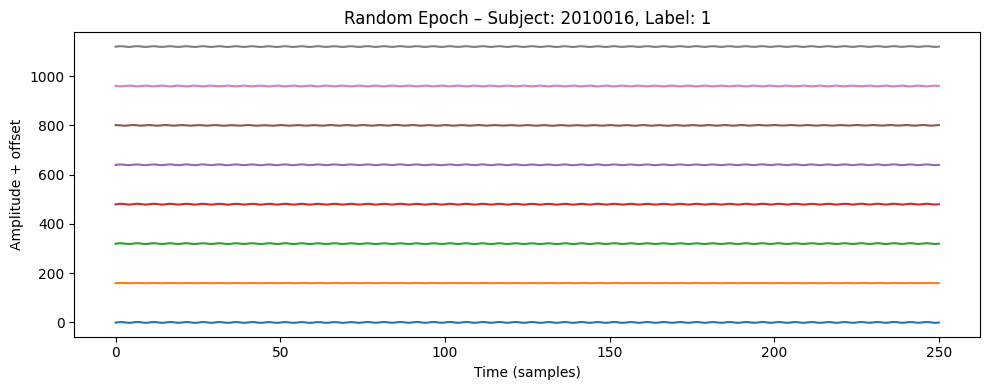

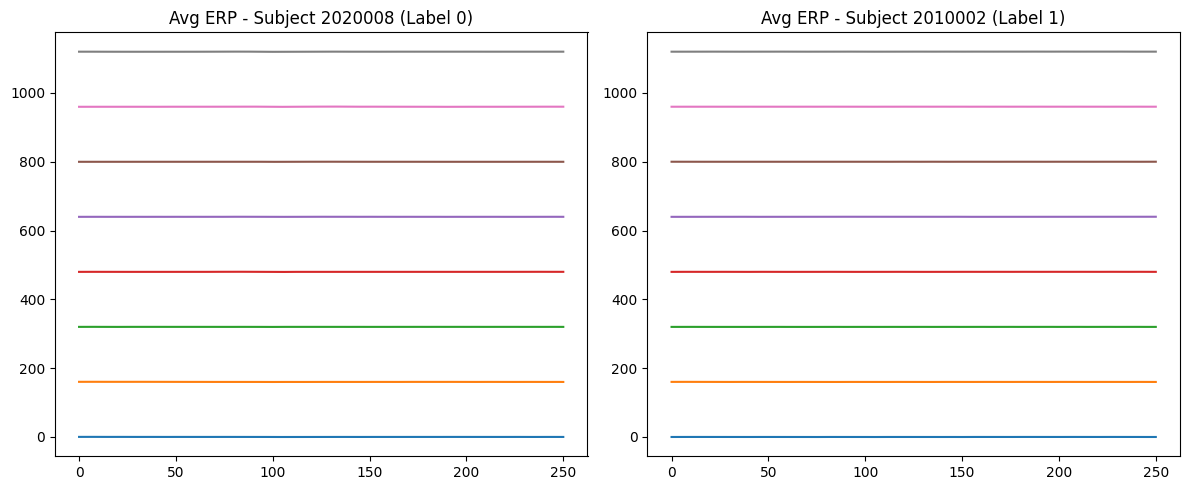

Label distribution: Counter({0: 13920, 1: 11520})


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Load the saved data
data = np.load(r"C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\Subject wise split\modma_subjectwise_normalized.npz")
X, y, subjects = data["X"], data["y"], data["subjects"]

# 1. Plot one random epoch
idx = random.randint(0, len(X) - 1)
plt.figure(figsize=(10, 4))
plt.title(f"Random Epoch – Subject: {subjects[idx]}, Label: {y[idx]}")
for ch in range(0, 128, 16):
    plt.plot(X[idx, ch, :, 0] + ch * 10)  # Offset for clarity
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude + offset")
plt.tight_layout()
plt.show()

# 2. Compare avg ERP for 2 subjects (1 from each class)
subj_0 = subjects[y == 0][0]
subj_1 = subjects[y == 1][0]

mean_0 = X[subjects == subj_0].mean(axis=0)
mean_1 = X[subjects == subj_1].mean(axis=0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title(f"Avg ERP - Subject {subj_0} (Label 0)")
for ch in range(0, 128, 16):
    plt.plot(mean_0[ch, :, 0] + ch * 10)
plt.subplot(1, 2, 2)
plt.title(f"Avg ERP - Subject {subj_1} (Label 1)")
for ch in range(0, 128, 16):
    plt.plot(mean_1[ch, :, 0] + ch * 10)
plt.tight_layout()
plt.show()

# 3. Label distribution
from collections import Counter
print("Label distribution:", Counter(y))


In [1]:
import numpy as np
import os

# === Load the big file ===
data = np.load(r"C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\Subject wise split\modma_subjectwise_normalized.npz")
X = data['X']
y = data['y']
subjects = data['subjects']

# === Output folder ===
out_dir = "modma_per_subject"
os.makedirs(out_dir, exist_ok=True)

# === Save per subject ===
unique_subjects = np.unique(subjects)
for subj in unique_subjects:
    idx = np.where(subjects == subj)[0]
    X_subj = X[idx]
    y_subj = y[idx]
    
    np.savez_compressed(
        os.path.join(out_dir, f"subject_{subj}.npz"),
        X=X_subj,
        y=y_subj,
        subject=subj
    )
    print(f"✅ Saved subject {subj} with {len(idx)} samples — {X_subj.shape}")

print(f"Done! Saved {len(unique_subjects)} subject files in {out_dir}")


✅ Saved subject 2010002 with 480 samples — (480, 128, 251, 1)
✅ Saved subject 2010004 with 480 samples — (480, 128, 251, 1)
✅ Saved subject 2010005 with 480 samples — (480, 128, 251, 1)
✅ Saved subject 2010006 with 480 samples — (480, 128, 251, 1)
✅ Saved subject 2010008 with 480 samples — (480, 128, 251, 1)
✅ Saved subject 2010010 with 480 samples — (480, 128, 251, 1)
✅ Saved subject 2010011 with 480 samples — (480, 128, 251, 1)
✅ Saved subject 2010012 with 480 samples — (480, 128, 251, 1)
✅ Saved subject 2010013 with 480 samples — (480, 128, 251, 1)
✅ Saved subject 2010015 with 480 samples — (480, 128, 251, 1)
✅ Saved subject 2010016 with 480 samples — (480, 128, 251, 1)
✅ Saved subject 2010018 with 480 samples — (480, 128, 251, 1)
✅ Saved subject 2010019 with 480 samples — (480, 128, 251, 1)
✅ Saved subject 2010021 with 480 samples — (480, 128, 251, 1)
✅ Saved subject 2010022 with 480 samples — (480, 128, 251, 1)
✅ Saved subject 2010023 with 480 samples — (480, 128, 251, 1)
✅ Saved 

In [7]:
import os
import shutil
import random

# Source folder
src_folder = r"C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\Subject wise split\modma_per_subject"

# Destination folders
train_folder = os.path.join(src_folder, "train")
test_folder = os.path.join(src_folder, "test")

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# List all .npz files directly in src_folder
files = [f for f in os.listdir(src_folder) if f.endswith(".npz")]

# Shuffle reproducibly
random.seed(42)
random.shuffle(files)

# 42 train / 11 test
train_files = files[:42]
test_files = files[42:]

# Move files
for f in train_files:
    shutil.move(os.path.join(src_folder, f), os.path.join(train_folder, f))
for f in test_files:
    shutil.move(os.path.join(src_folder, f), os.path.join(test_folder, f))

# Save subject lists
with open(os.path.join(src_folder, "train_subjects.txt"), "w") as f:
    f.write("\n".join(train_files))
with open(os.path.join(src_folder, "test_subjects.txt"), "w") as f:
    f.write("\n".join(test_files))

print(f"✅ Train: {len(train_files)} files")
print(f"✅ Test: {len(test_files)} files")
print("📂 Folder structure ready.")


✅ Train: 42 files
✅ Test: 11 files
📂 Folder structure ready.


In [9]:
import shutil
import os

src_folder = r"C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\Subject wise split\modma_per_subject"
output_zip = os.path.join(os.path.dirname(src_folder), "modma_per_subject.zip")

shutil.make_archive(output_zip.replace('.zip', ''), 'zip', src_folder)
print("✅ Zipped in place:", output_zip)


✅ Zipped in place: C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\Subject wise split\modma_per_subject.zip


In [6]:
import os

src_folder = r"C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\Subject wise split\modma_per_subject"

for f in os.listdir(src_folder):
    print(f)


subject_2010002.npz
subject_2010004.npz
subject_2010005.npz
subject_2010006.npz
subject_2010008.npz
subject_2010010.npz
subject_2010011.npz
subject_2010012.npz
subject_2010013.npz
subject_2010015.npz
subject_2010016.npz
subject_2010018.npz
subject_2010019.npz
subject_2010021.npz
subject_2010022.npz
subject_2010023.npz
subject_2010024.npz
subject_2010025.npz
subject_2010026.npz
subject_2010028.npz
subject_2010030.npz
subject_2010033.npz
subject_2010034.npz
subject_2010036.npz
subject_2020008.npz
subject_2020010.npz
subject_2020013.npz
subject_2020014.npz
subject_2020015.npz
subject_2020016.npz
subject_2020018.npz
subject_2020019.npz
subject_2020020.npz
subject_2020021.npz
subject_2020022.npz
subject_2020023.npz
subject_2020025.npz
subject_2020026.npz
subject_2020027.npz
subject_2020029.npz
subject_2030002.npz
subject_2030003.npz
subject_2030004.npz
subject_2030005.npz
subject_2030006.npz
subject_2030007.npz
subject_2030009.npz
subject_2030014.npz
subject_2030017.npz
subject_2030018.npz


In [2]:
import numpy as np

n_subjects = 53
epochs_per_subject = 480

# Repeat each subject ID 480 times
subject_ids = np.repeat(np.arange(n_subjects), epochs_per_subject)

print(subject_ids.shape)  # should be (25440,)
print("Unique subject IDs:", np.unique(subject_ids))
data = np.load(r"C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\Subject wise split\modma_subjectwise_normalized.npz")
print(data.files)


(25440,)
Unique subject IDs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
['X', 'y', 'subjects']


In [1]:
import numpy as np

# Path to one of your subject files
subject_path = r"C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\Subject wise split\modma_per_subject\train\subject_2010002.npz"

# Load .npz
data = np.load(subject_path, allow_pickle=True)

print(f"Keys in file: {list(data.keys())}")
print("="*50)

# Inspect each key
for key in data:
    arr = data[key]
    print(f"Key: {key}")
    print(f"  Shape: {arr.shape}")
    print(f"  Dtype: {arr.dtype}")
    
    # If it's small or 1D, print some values
    if arr.size <= 20:
        print(f"  Values: {arr}")
    else:
        print(f"  First few values: {arr.ravel()[:10]}")
    print("-"*50)

data.close()


Keys in file: ['X', 'y', 'subject']
Key: X
  Shape: (480, 128, 251, 1)
  Dtype: float64
  First few values: [-0.89141397 -0.58008515  0.61896219  1.04402911  0.09525612 -0.93303733
 -0.64152888  0.53723508  0.93682533 -0.0342335 ]
--------------------------------------------------
Key: y
  Shape: (480,)
  Dtype: int64
  First few values: [1 1 1 1 1 1 1 1 1 1]
--------------------------------------------------
Key: subject
  Shape: ()
  Dtype: <U7
  Values: 2010002
--------------------------------------------------


In [12]:
import os
import numpy as np
from collections import Counter

folder = r"C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\Subject wise split\modma_per_subject\train"

for file in os.listdir(folder):
    if file.endswith(".npz"):
        path = os.path.join(folder, file)
        data = np.load(path)
        y = data["y"]
        counts = Counter(y.tolist())
        print(f"{file}: {dict(counts)}")


subject_2010002.npz: {1: 480}
subject_2010005.npz: {1: 480}
subject_2010006.npz: {1: 480}
subject_2010008.npz: {1: 480}
subject_2010010.npz: {1: 480}
subject_2010015.npz: {1: 480}
subject_2010016.npz: {1: 480}
subject_2010018.npz: {1: 480}
subject_2010019.npz: {1: 480}
subject_2010021.npz: {1: 480}
subject_2010024.npz: {1: 480}
subject_2010026.npz: {1: 480}
subject_2010028.npz: {1: 480}
subject_2010030.npz: {1: 480}
subject_2010033.npz: {1: 480}
subject_2010034.npz: {1: 480}
subject_2010036.npz: {1: 480}
subject_2020008.npz: {0: 480}
subject_2020010.npz: {0: 480}
subject_2020013.npz: {0: 480}
subject_2020014.npz: {0: 480}
subject_2020015.npz: {0: 480}
subject_2020016.npz: {0: 480}
subject_2020018.npz: {0: 480}
subject_2020019.npz: {0: 480}
subject_2020020.npz: {0: 480}
subject_2020021.npz: {0: 480}
subject_2020023.npz: {0: 480}
subject_2020025.npz: {0: 480}
subject_2020026.npz: {0: 480}
subject_2020027.npz: {0: 480}
subject_2020029.npz: {0: 480}
subject_2030003.npz: {0: 480}
subject_20

In [3]:
import os
import numpy as np
train_folder = r'C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\Subject wise split\modma_per_subject\train'
test_folder = r'C:\Modma_dataset\EEG_128channels_ERP_lanzhou_2015\EEG_128channels_ERP_lanzhou_2015\Subject wise split\modma_per_subject\test'

def load_all_subjects(folder_path):
    Xs, ys = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith('.npz'):
            full_path = os.path.join(folder_path, filename)
            X_agg, y_label = aggregate_subject_epochs(full_path)
            Xs.append(X_agg)
            ys.append(y_label)
    Xs = np.array(Xs)  # (num_subjects, 128, 251, 1)
    ys = np.array(ys)  # (num_subjects,)
    return Xs, ys

X_train, y_train = load_all_subjects(train_folder)
X_test, y_test = load_all_subjects(test_folder)

print("Train X shape:", X_train.shape)
print("Train y shape:", y_train.shape)
print("Test X shape:", X_test.shape)
print("Test y shape:", y_test.shape)


Train X shape: (42, 128, 251, 1)
Train y shape: (42,)
Test X shape: (11, 128, 251, 1)
Test y shape: (11,)
